### Import packages

In [1]:
import itertools
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from utilities import cal_score, convert_types

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/lightgbm/__init__.py:45: FutureWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS will be built by the Apple Clang compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you won't need to install the gcc compiler anymore.
Instead of that, you'll need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", FutureWarning)


### Columns

In [2]:
cols_num = ['txn_dt', 'total_floor', 'building_complete_dt', 'parking_area', 'parking_price', 'txn_floor', 'land_area', 'building_area', 'lat', 'lon', 'village_income_median', 'town_population', 'town_area', 'town_population_density', 'doc_rate', 'master_rate', 'bachelor_rate', 'jobschool_rate', 'highschool_rate', 'junior_rate', 'elementary_rate', 'born_rate', 'death_rate', 'marriage_rate', 'divorce_rate', 'N_50', 'N_500', 'N_1000', 'N_5000', 'N_10000', 'I_10', 'I_50', 'I_100', 'I_250', 'I_500', 'I_1000', 'I_5000', 'I_10000', 'I_MIN', 'II_10', 'II_50', 'II_100', 'II_250', 'II_500', 'II_1000', 'II_5000', 'II_10000', 'II_MIN', 'III_10', 'III_50', 'III_100', 'III_250', 'III_500', 'III_1000', 'III_5000', 'III_10000', 'III_MIN', 'IV_10', 'IV_50', 'IV_100', 'IV_250', 'IV_500', 'IV_1000', 'IV_5000', 'IV_10000', 'IV_MIN', 'V_10', 'V_50', 'V_100', 'V_250', 'V_500', 'V_1000', 'V_5000', 'V_10000', 'V_MIN', 'VI_50', 'VI_100', 'VI_250', 'VI_500', 'VI_1000', 'VI_5000', 'VI_10000', 'VI_MIN', 'VII_10', 'VII_50', 'VII_100', 'VII_250', 'VII_500', 'VII_1000', 'VII_5000', 'VII_10000', 'VII_MIN', 'VIII_10', 'VIII_50', 'VIII_100', 'VIII_250', 'VIII_500', 'VIII_1000', 'VIII_5000', 'VIII_10000', 'VIII_MIN', 'IX_10', 'IX_50', 'IX_100', 'IX_250', 'IX_500', 'IX_1000', 'IX_5000', 'IX_10000', 'IX_MIN', 'X_10', 'X_50', 'X_100', 'X_250', 'X_500', 'X_1000', 'X_5000', 'X_10000', 'X_MIN', 'XI_10', 'XI_50', 'XI_100', 'XI_250', 'XI_500', 'XI_1000', 'XI_5000', 'XI_10000', 'XI_MIN', 'XII_10', 'XII_50', 'XII_100', 'XII_250', 'XII_500', 'XII_1000', 'XII_5000', 'XII_10000', 'XII_MIN', 'XIII_10', 'XIII_50', 'XIII_100', 'XIII_250', 'XIII_500', 'XIII_1000', 'XIII_5000', 'XIII_10000', 'XIII_MIN', 'XIV_10', 'XIV_50', 'XIV_100', 'XIV_250', 'XIV_500', 'XIV_1000', 'XIV_5000', 'XIV_10000', 'XIV_MIN']
cols_cat = ['building_material', 'city', 'building_type', 'building_use', 'parking_way', 'town', 'village']
cols_bin = ['I_index_50', 'I_index_500', 'I_index_1000', 'II_index_50', 'II_index_500', 'II_index_1000', 'III_index_50', 'III_index_500', 'III_index_1000', 'IV_index_50', 'IV_index_500', 'IV_index_1000', 'IV_index_5000', 'V_index_50', 'V_index_500', 'V_index_1000', 'VI_10', 'VI_index_50', 'VI_index_500', 'VI_index_1000', 'VII_index_50', 'VII_index_500', 'VII_index_1000', 'VIII_index_50', 'VIII_index_500', 'VIII_index_1000', 'IX_index_50', 'IX_index_500', 'IX_index_1000', 'IX_index_5000', 'X_index_50', 'X_index_500', 'X_index_1000', 'XI_index_50', 'XI_index_500', 'XI_index_1000', 'XI_index_5000', 'XI_index_10000', 'XII_index_50', 'XII_index_500', 'XII_index_1000', 'XIII_index_50', 'XIII_index_500', 'XIII_index_1000', 'XIII_index_5000', 'XIII_index_10000', 'XIV_index_50', 'XIV_index_500', 'XIV_index_1000']
cols_feats = cols_num + cols_cat + cols_bin

col_target = 'total_price'
col_target_log1p = 'target'

### Read data

In [3]:
df = pd.read_csv('dataset/train.csv', dtype=object)

In [4]:
df.columns

Index(['building_id', 'building_material', 'city', 'txn_dt', 'total_floor',
       'building_type', 'building_use', 'building_complete_dt', 'parking_way',
       'parking_area',
       ...
       'XIV_500', 'XIV_index_500', 'XIV_1000', 'XIV_index_1000', 'XIV_5000',
       'XIV_index_5000', 'XIV_10000', 'XIV_index_10000', 'XIV_MIN',
       'total_price'],
      dtype='object', length=235)

### Preprocessing

In [5]:
# Convert types
df = convert_types(df, cols_num, col_target=col_target)

# Generate feats (train-test-same feats)
#create_feats(df)

### Feat engineering

In [6]:
from feature_engineering import CategoricalColumnsEncoder

In [7]:
class FeatureEngineering():
    def __init__(self):
        pass
    
    def fit_transform(self, df, cols_cat, cols_bin):
        df = df.copy()
        # Denote categorical-type
        self.cat_encoder = CategoricalColumnsEncoder(mode='pandas')
        self.cat_encoder.fit_transform(df, cols_cat+cols_bin)
        return df
    
    def transform(self, df):
        df = df.copy()
        self.cat_encoder.transform(df)
        return df

### Objective

In [8]:
def square_log1p_error_m10p(x): return np.square(np.log1p(x) - np.log1p(0.9*x))
def square_log1p_error_p10p(x): return np.square(np.log1p(x) - np.log1p(1.1*x))

In [9]:
x = np.array([10**n for n in range(3, 7)])
print(x)
print(np.log1p(0.9*x) - np.log1p(x))
print(np.log1p(1.1*x) - np.log1p(x))
print(square_log1p_error_m10p(x))
print(square_log1p_error_p10p(x))

[   1000   10000  100000 1000000]
[-0.10524952 -0.10534941 -0.1053594  -0.1053604 ]
[0.09521936 0.09530109 0.09530927 0.09531009]
[0.01107746 0.0110985  0.0111006  0.01110081]
[0.00906673 0.0090823  0.00908386 0.00908401]


In [10]:
res_thres_low = -0.10524952
res_thres_high = 0.09521936

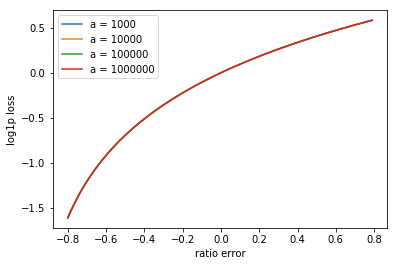

In [11]:
x_plot = np.arange(-0.8, 0.8, 0.01)
for a in [10**n for n in range(3, 7)]:
    plt.plot(x_plot, np.log1p(a*(1+x_plot)) - np.log1p(a), label='a = '+str(a))
plt.xlabel('ratio error'); plt.ylabel('log1p loss'); plt.legend()
plt.show()

In [12]:
def custom_objective(y_pred, dataset_true):
    y_true = dataset_true.get_label().values
    residual = y_pred - y_true
    grad = np.where((res_thres_low < residual) & (residual < res_thres_high), 
                    0.2*residual, 2.*residual)
    hess = np.where((res_thres_low < residual) & (residual < res_thres_high),
                    0.2, 2.0)
    return grad, hess

def custom_metric(y_pred, dataset_true):
    y_true = dataset_true.get_label().values
    residual = y_pred - y_true
    c_mse = np.square(residual)
    #c_mse = np.zeros(len(residual), dtype='float32')
    cond1 = residual <= res_thres_low
    c_mse[cond1] = c_mse[cond1] - 0.9 * res_thres_low**2
    cond2 = res_thres_high <= residual
    c_mse[cond2] = c_mse[cond2] - 0.9 * res_thres_high**2
    cond3 = (~cond1) & (~cond2)
    c_mse[cond3] = c_mse[cond3] * 0.1
    #c_mse = np.piecewise(residual, 
    #                     [residual <= res_thres_low, 
    #                      (res_thres_low < residual)&(residual < res_thres_high),
    #                      res_thres_high <= residual],
    #                     [lambda x: np.square(x)-0.99*res_thres_low**2, 
    #                      lambda x: 0.01*np.square(x), 
    #                      lambda x: np.square(x)-0.99*res_thres_high**2]
    #                    )
    return 'c_mse', np.mean(c_mse), False

def hit_rate(y_pred, dataset_true):
    y_true = dataset_true.get_label()
    y_pred = np.clip(np.exp(y_pred.astype("float")) - 1, 0, None)
    y_true = np.clip(np.exp(y_true.astype("float")) - 1, 0, None)
    rate = np.mean(np.abs(y_pred - y_true) <= 0.1 * y_true)
    mape = np.mean(np.abs(y_pred - y_true) / y_true)
    return "hit_rate", np.round(rate, decimals=4)*10000 + (1-mape), True

In [15]:
def test_custom_metric(residual):
    return np.piecewise(residual, 
                         [residual <= res_thres_low, 
                          (res_thres_low < residual)&(residual < res_thres_high),
                          res_thres_high <= residual],
                         [lambda x: np.square(x)-0.9*res_thres_low**2, 
                          lambda x: 0.1*np.square(x), 
                          lambda x: np.square(x)-0.9*res_thres_high**2]
                        )

In [13]:
def test_custom_metric2(residual):
    c_mse = np.square(residual)
    #c_mse = np.zeros(len(residual), dtype='float32')
    cond1 = residual <= res_thres_low
    c_mse[cond1] = c_mse[cond1] - 0.9 * res_thres_low**2
    cond2 = res_thres_high <= residual
    c_mse[cond2] = c_mse[cond2] - 0.9 * res_thres_high**2
    cond3 = (~cond1) & (~cond2)
    c_mse[cond3] = c_mse[cond3] * 0.1
    return c_mse

In [16]:
test_custom_metric(np.arange(-1., 1., 0.1))

array([9.90030285e-01, 8.00030285e-01, 6.30030285e-01, 4.80030285e-01,
       3.50030285e-01, 2.40030285e-01, 1.50030285e-01, 8.00302847e-02,
       3.00302847e-02, 1.00000000e-03, 4.93038066e-33, 1.83994613e-03,
       3.18399461e-02, 8.18399461e-02, 1.51839946e-01, 2.41839946e-01,
       3.51839946e-01, 4.81839946e-01, 6.31839946e-01, 8.01839946e-01])

In [17]:
test_custom_metric2(np.arange(-1., 1., 0.1))

array([9.90030285e-01, 8.00030285e-01, 6.30030285e-01, 4.80030285e-01,
       3.50030285e-01, 2.40030285e-01, 1.50030285e-01, 8.00302847e-02,
       3.00302847e-02, 1.00000000e-03, 4.93038066e-33, 1.83994613e-03,
       3.18399461e-02, 8.18399461e-02, 1.51839946e-01, 2.41839946e-01,
       3.51839946e-01, 4.81839946e-01, 6.31839946e-01, 8.01839946e-01])

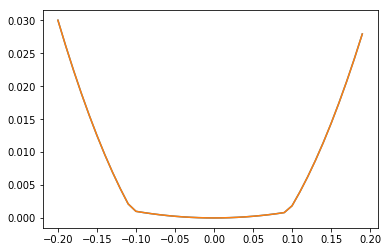

In [18]:
x_plot = np.arange(-0.2, 0.2, 0.01)
plt.plot(x_plot, test_custom_metric(x_plot))
plt.plot(x_plot, test_custom_metric2(x_plot))
plt.show()

### First trial

In [20]:
# pars
is_log1p = True # if train on log1p target
# pars

# grid search
params_gsearch = {'task': ['train'],'boosting_type': ['gbdt'],
                  'metric': ['mae'],
                  #'objective': ['regression'], # 'mae', 'mape', 'mse'
                  'num_leaves': [255],
                  'learning_rate': [0.015],
                  'feature_fraction': [0.5],
                  'min_data_in_leaf': [5],
                  'lambda_l1': [0.1]}

params_names = params_gsearch.keys()

gsearch = {}
folds = KFold(n_splits=3)
for i_fold, (itrain, ival) in enumerate(folds.split(df)): # kfold
    print('==== Fold', i_fold+1, '====')
    
    # split train, val
    df_train = df.loc[itrain]
    df_val = df.loc[ival]
    
    # feat eng
    feat_eng = FeatureEngineering()
    df_train = feat_eng.fit_transform(df_train, cols_cat, cols_bin)
    df_val = feat_eng.transform(df_val)

    # Construct lgb dataset
    if is_log1p:
        lgb_train = lgb.Dataset(df_train[cols_feats], df_train['target']).construct()
        lgb_val = lgb.Dataset(df_val[cols_feats], df_val['target'], reference=lgb_train).construct()
    else:
        lgb_train = lgb.Dataset(df_train[cols_feats], df_train['total_price']).construct()
        lgb_val = lgb.Dataset(df_val[cols_feats], df_val['total_price'], reference=lgb_train).construct()
        
    # grid search
    for values in itertools.product(*[params_gsearch[key] for key in params_names]):
        params = dict(zip(params_names, values))
        print('params:', params)
        
        model = lgb.train(params, lgb_train,
                          num_boost_round=10000, # 10000
                          valid_sets=[lgb_train, lgb_val],
                          verbose_eval=200,
                          fobj=custom_objective,
                          #feval=custom_metric,  # hit_rate
                          #early_stopping_rounds=200,
                          )
        y_pred = model.predict(df_val[cols_feats])
        
        if is_log1p:
            y_pred_expm1 = np.expm1(y_pred)
            y_pred_final = np.clip(y_pred_expm1, 0, None)
        else:
            y_pred_final = y_pred
            
        score = cal_score(df_val['total_price'], y_pred_final)
        print(score)
        tuple_params = tuple(params.items())
        gsearch[tuple_params] = gsearch.get(tuple_params, []) + [score]        

# aggregate, sort gsearch results
gsearch_results = [[key, np.mean(val), val] for key, val in gsearch.items()]
gsearch_results.sort(key= lambda x: x[1], reverse = True)
display(gsearch_results)

==== Fold 1 ====
params: {'task': 'train', 'boosting_type': 'gbdt', 'metric': 'mae', 'num_leaves': 255, 'learning_rate': 0.015, 'feature_fraction': 0.5, 'min_data_in_leaf': 5, 'lambda_l1': 0.1}
[200]	training's l1: 0.756412	valid_1's l1: 0.755771
[400]	training's l1: 0.10245	valid_1's l1: 0.155038
[600]	training's l1: 0.0753303	valid_1's l1: 0.144916
[800]	training's l1: 0.0625253	valid_1's l1: 0.142219
[1000]	training's l1: 0.055046	valid_1's l1: 0.140751
[1200]	training's l1: 0.048956	valid_1's l1: 0.13934
[1400]	training's l1: 0.0441041	valid_1's l1: 0.138359
[1600]	training's l1: 0.0402993	valid_1's l1: 0.137687
[1800]	training's l1: 0.0371449	valid_1's l1: 0.137201
[2000]	training's l1: 0.034522	valid_1's l1: 0.136831
[2200]	training's l1: 0.0322621	valid_1's l1: 0.136528
[2400]	training's l1: 0.0302563	valid_1's l1: 0.136281
[2600]	training's l1: 0.0285141	valid_1's l1: 0.136098
[2800]	training's l1: 0.0269457	valid_1's l1: 0.135938
[3000]	training's l1: 0.0255371	valid_1's l1: 0

[8000]	training's l1: 0.0140482	valid_1's l1: 0.134181
[8200]	training's l1: 0.0140482	valid_1's l1: 0.134181
[8400]	training's l1: 0.0140482	valid_1's l1: 0.134181
[8600]	training's l1: 0.0140482	valid_1's l1: 0.134181
[8800]	training's l1: 0.0140482	valid_1's l1: 0.134181
[9000]	training's l1: 0.0140482	valid_1's l1: 0.134181
[9200]	training's l1: 0.0140482	valid_1's l1: 0.134181
[9400]	training's l1: 0.0140482	valid_1's l1: 0.134181
[9600]	training's l1: 0.0140482	valid_1's l1: 0.134181
[9800]	training's l1: 0.0140482	valid_1's l1: 0.134181
[10000]	training's l1: 0.0140482	valid_1's l1: 0.134181
5420.863933431016


[[(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('metric', 'mae'),
   ('num_leaves', 255),
   ('learning_rate', 0.015),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 5),
   ('lambda_l1', 0.1)),
  5463.194236854902,
  [5427.8567774314315, 5540.861999702255, 5420.863933431016]]]

In [22]:
%%time
# pars
is_log1p = True # if train on log1p target
# pars

# grid search
params_gsearch = {'task': ['train'],'boosting_type': ['gbdt'],
                  'metric': ['mape'],
                  #'objective': ['regression'], # 'mae', 'mape', 'mse'
                  'num_leaves': [255],
                  'learning_rate': [0.015],
                  'feature_fraction': [0.5],
                  'min_data_in_leaf': [5],
                  'lambda_l1': [0.1]}

params_names = params_gsearch.keys()

gsearch = {}
folds = KFold(n_splits=3)
for i_fold, (itrain, ival) in enumerate(folds.split(df)): # kfold
    print('==== Fold', i_fold+1, '====')
    
    # split train, val
    df_train = df.loc[itrain]
    df_val = df.loc[ival]
    
    # feat eng
    feat_eng = FeatureEngineering()
    df_train = feat_eng.fit_transform(df_train, cols_cat, cols_bin)
    df_val = feat_eng.transform(df_val)

    # Construct lgb dataset
    if is_log1p:
        lgb_train = lgb.Dataset(df_train[cols_feats], df_train['target']).construct()
        lgb_val = lgb.Dataset(df_val[cols_feats], df_val['target'], reference=lgb_train).construct()
    else:
        lgb_train = lgb.Dataset(df_train[cols_feats], df_train['total_price']).construct()
        lgb_val = lgb.Dataset(df_val[cols_feats], df_val['total_price'], reference=lgb_train).construct()
        
    # grid search
    for values in itertools.product(*[params_gsearch[key] for key in params_names]):
        params = dict(zip(params_names, values))
        print('params:', params)
        
        model = lgb.train(params, lgb_train,
                          num_boost_round=10000, # 10000
                          valid_sets=[lgb_train, lgb_val],
                          verbose_eval=200,
                          fobj=custom_objective,
                          #feval=custom_metric,  # hit_rate
                          early_stopping_rounds=1000,
                          )
        y_pred = model.predict(df_val[cols_feats])
        
        if is_log1p:
            y_pred_expm1 = np.expm1(y_pred)
            y_pred_final = np.clip(y_pred_expm1, 0, None)
        else:
            y_pred_final = y_pred
            
        score = cal_score(df_val['total_price'], y_pred_final)
        print(score)
        tuple_params = tuple(params.items())
        gsearch[tuple_params] = gsearch.get(tuple_params, []) + [score]        

# aggregate, sort gsearch results
gsearch_results = [[key, np.mean(val), val] for key, val in gsearch.items()]
gsearch_results.sort(key= lambda x: x[1], reverse = True)
display(gsearch_results)

==== Fold 1 ====
params: {'task': 'train', 'boosting_type': 'gbdt', 'metric': 'mape', 'num_leaves': 255, 'learning_rate': 0.015, 'feature_fraction': 0.5, 'min_data_in_leaf': 5, 'lambda_l1': 0.1}
Training until validation scores don't improve for 1000 rounds.
[200]	training's mape: 0.0483623	valid_1's mape: 0.048245
[400]	training's mape: 0.00663012	valid_1's mape: 0.0100476
[600]	training's mape: 0.00488967	valid_1's mape: 0.00941735
[800]	training's mape: 0.00405652	valid_1's mape: 0.00924537
[1000]	training's mape: 0.00357217	valid_1's mape: 0.00915362
[1200]	training's mape: 0.00317773	valid_1's mape: 0.00906402
[1400]	training's mape: 0.00286254	valid_1's mape: 0.00900088
[1600]	training's mape: 0.00261522	valid_1's mape: 0.00895765
[1800]	training's mape: 0.00241002	valid_1's mape: 0.00892648
[2000]	training's mape: 0.0022396	valid_1's mape: 0.0089028
[2200]	training's mape: 0.0020925	valid_1's mape: 0.00888331
[2400]	training's mape: 0.00196232	valid_1's mape: 0.00886763
[2600]	t

[[(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('metric', 'mape'),
   ('num_leaves', 255),
   ('learning_rate', 0.015),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 5),
   ('lambda_l1', 0.1)),
  5463.19423695169,
  [5427.8567774314315, 5541.861999852586, 5419.86393357105]]]

CPU times: user 1h 51min 16s, sys: 2min 28s, total: 1h 53min 44s
Wall time: 10min 26s


In [40]:
# pars
is_log1p = True # if train on log1p target
# pars

# grid search
params_gsearch = {'task': ['train'],'boosting_type': ['gbdt'],
                  #'metric': [['mse', 'mae']],
                  #'objective': ['regression'], # 'mae', 'mape', 'mse'
                  'num_leaves': [255],
                  'learning_rate': [0.015],
                  'feature_fraction': [0.5],
                  'min_data_in_leaf': [5],
                  'lambda_l1': [0.1]}

params_names = params_gsearch.keys()

gsearch = {}
folds = KFold(n_splits=3)
for i_fold, (itrain, ival) in enumerate(folds.split(df)): # kfold
    print('==== Fold', i_fold+1, '====')
    
    # split train, val
    df_train = df.loc[itrain]
    df_val = df.loc[ival]
    
    # feat eng
    feat_eng = FeatureEngineering()
    df_train = feat_eng.fit_transform(df_train, cols_cat, cols_bin)
    df_val = feat_eng.transform(df_val)

    # Construct lgb dataset
    if is_log1p:
        lgb_train = lgb.Dataset(df_train[cols_feats], df_train['target']).construct()
        lgb_val = lgb.Dataset(df_val[cols_feats], df_val['target'], reference=lgb_train).construct()
    else:
        lgb_train = lgb.Dataset(df_train[cols_feats], df_train['total_price']).construct()
        lgb_val = lgb.Dataset(df_val[cols_feats], df_val['total_price'], reference=lgb_train).construct()
        
    # grid search
    for values in itertools.product(*[params_gsearch[key] for key in params_names]):
        params = dict(zip(params_names, values))
        print('params:', params)
        
        model = lgb.train(params, lgb_train,
                          num_boost_round=10000,
                          valid_sets=lgb_val,
                          verbose_eval=200,
                          fobj=custom_objective,
                          feval=custom_metric,  # hit_rate
                          early_stopping_rounds=200,
                          )
        y_pred = model.predict(df_val[cols_feats])
        
        if is_log1p:
            y_pred_expm1 = np.expm1(y_pred)
            y_pred_final = np.clip(y_pred_expm1, 0, None)
        else:
            y_pred_final = y_pred
            
        score = cal_score(df_val['total_price'], y_pred_final)
        print(score)
        tuple_params = tuple(params.items())
        gsearch[tuple_params] = gsearch.get(tuple_params, []) + [score]        

# aggregate, sort gsearch results
gsearch_results = [[key, np.mean(val), val] for key, val in gsearch.items()]
gsearch_results.sort(key= lambda x: x[1], reverse = True)
display(gsearch_results)

==== Fold 1 ====
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'regression', 'num_leaves': 255, 'learning_rate': 0.015, 'feature_fraction': 0.5, 'min_data_in_leaf': 5, 'lambda_l1': 0.1}
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's l2: 0.639804	valid_0's c_mse: 0.628912
[400]	valid_0's l2: 0.0504425	valid_0's c_mse: 0.0435769
[600]	valid_0's l2: 0.0462463	valid_0's c_mse: 0.0396384
[800]	valid_0's l2: 0.0456643	valid_0's c_mse: 0.0391245
[1000]	valid_0's l2: 0.0453919	valid_0's c_mse: 0.038924
[1200]	valid_0's l2: 0.0452014	valid_0's c_mse: 0.0387737
[1400]	valid_0's l2: 0.0450591	valid_0's c_mse: 0.0386603
[1600]	valid_0's l2: 0.0449438	valid_0's c_mse: 0.0385658
[1800]	valid_0's l2: 0.044862	valid_0's c_mse: 0.0385002
[2000]	valid_0's l2: 0.0447929	valid_0's c_mse: 0.0384429
[2200]	valid_0's l2: 0.0447573	valid_0's c_mse: 0.0384133
[2400]	valid_0's l2: 0.0447402	valid_0's c_mse: 0.0383995
Early stopping, best iteration is:
[2338]	val

[[(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'regression'),
   ('num_leaves', 255),
   ('learning_rate', 0.015),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 5),
   ('lambda_l1', 0.1)),
  5233.8559946835585,
  [5212.852030778913, 5322.856877528791, 5165.859075742971]]]

### Grid Search

In [23]:
# pars
is_log1p = True # if train on log1p target
# pars

# grid search
params_fix = {'task': 'train',
              'boosting_type': 'gbdt',
              #'objective': 'mse',
              'metric': 'mape',
              'learning_rate': 0.015,
              }

####  Round 1

In [24]:
%%time
params_gsearch1 = {'num_leaves': [63, 255, 511],           # may reduce in dim-reduction exp
                   'feature_fraction': [0.5, 0.75, 1.0],
                   'min_data_in_leaf': [5, 20, 50]
                   }

gsearch = {}
folds = KFold(n_splits=3, shuffle=True, random_state=123)
for i_fold, (itrain, ival) in enumerate(folds.split(df)): # kfold
    print('==== Fold', i_fold+1, '====')
    
    # split train, val
    df_train = df.loc[itrain]
    df_val = df.loc[ival]
    
    # feat eng
    feat_eng = FeatureEngineering()
    df_train = feat_eng.fit_transform(df_train, cols_cat, cols_bin)
    df_val = feat_eng.transform(df_val)

    # Construct lgb dataset
    if is_log1p:
        lgb_train = lgb.Dataset(df_train[cols_feats], df_train['target']).construct()
        lgb_val = lgb.Dataset(df_val[cols_feats], df_val['target'], reference=lgb_train).construct()
    else:
        lgb_train = lgb.Dataset(df_train[cols_feats], df_train['total_price']).construct()
        lgb_val = lgb.Dataset(df_val[cols_feats], df_val['total_price'], reference=lgb_train).construct()
        
    # grid search
    for values in itertools.product(*[params_gsearch1[key] for key in params_gsearch1]):
        params = params_fix.copy()
        params.update( dict(zip(params_gsearch1.keys(), values)) )
        print('params:', params)

        model = lgb.train(params, lgb_train,
                          num_boost_round=10000,
                          fobj=custom_objective,
                          #feval=custom_metric,  # hit_rate
                          valid_sets=lgb_val,
                          verbose_eval=2000,
                          early_stopping_rounds=1000)
        y_pred = model.predict(df_val[cols_feats])
        
        if is_log1p:
            y_pred_expm1 = np.expm1(y_pred)
            y_pred_final = np.clip(y_pred_expm1, 0, None)
        else:
            y_pred_final = y_pred
            
        score = cal_score(df_val['total_price'], y_pred_final)
        tuple_params = tuple(params.items())
        gsearch[tuple_params] = gsearch.get(tuple_params, []) + [score]

# aggregate, sort gsearch results
gsearch_results1 = [[key, np.mean(val), val] for key, val in gsearch.items()]
gsearch_results1.sort(key= lambda x: x[1], reverse=True)

==== Fold 1 ====
params: {'task': 'train', 'boosting_type': 'gbdt', 'metric': 'mape', 'learning_rate': 0.015, 'num_leaves': 63, 'feature_fraction': 0.5, 'min_data_in_leaf': 5}
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00918886
[4000]	valid_0's mape: 0.00888859
[6000]	valid_0's mape: 0.00874446
[8000]	valid_0's mape: 0.00867777
[10000]	valid_0's mape: 0.00863899
Did not meet early stopping. Best iteration is:
[10000]	valid_0's mape: 0.00863899
params: {'task': 'train', 'boosting_type': 'gbdt', 'metric': 'mape', 'learning_rate': 0.015, 'num_leaves': 63, 'feature_fraction': 0.5, 'min_data_in_leaf': 20}
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00916183
[4000]	valid_0's mape: 0.00891099
[6000]	valid_0's mape: 0.00875326
[8000]	valid_0's mape: 0.008685
[10000]	valid_0's mape: 0.00864628
Did not meet early stopping. Best iteration is:
[9999]	valid_0's mape: 0.00864626
params: {'task': 'train', 'boos

[2000]	valid_0's mape: 0.00893468
[4000]	valid_0's mape: 0.00884921
[6000]	valid_0's mape: 0.00883295
[8000]	valid_0's mape: 0.0088272
[10000]	valid_0's mape: 0.00882402
Did not meet early stopping. Best iteration is:
[9997]	valid_0's mape: 0.00882402
params: {'task': 'train', 'boosting_type': 'gbdt', 'metric': 'mape', 'learning_rate': 0.015, 'num_leaves': 511, 'feature_fraction': 0.5, 'min_data_in_leaf': 5}
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00876275
[4000]	valid_0's mape: 0.00872143
[6000]	valid_0's mape: 0.00871454
[8000]	valid_0's mape: 0.0087126
[10000]	valid_0's mape: 0.00871186
Did not meet early stopping. Best iteration is:
[10000]	valid_0's mape: 0.00871186
params: {'task': 'train', 'boosting_type': 'gbdt', 'metric': 'mape', 'learning_rate': 0.015, 'num_leaves': 511, 'feature_fraction': 0.5, 'min_data_in_leaf': 20}
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00874415
[4000]	valid

[6000]	valid_0's mape: 0.00903143
[8000]	valid_0's mape: 0.00897319
[10000]	valid_0's mape: 0.008937
Did not meet early stopping. Best iteration is:
[9999]	valid_0's mape: 0.00893699
params: {'task': 'train', 'boosting_type': 'gbdt', 'metric': 'mape', 'learning_rate': 0.015, 'num_leaves': 63, 'feature_fraction': 1.0, 'min_data_in_leaf': 50}
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00943039
[4000]	valid_0's mape: 0.00920157
[6000]	valid_0's mape: 0.00908028
[8000]	valid_0's mape: 0.00902457
[10000]	valid_0's mape: 0.008992
Did not meet early stopping. Best iteration is:
[10000]	valid_0's mape: 0.008992
params: {'task': 'train', 'boosting_type': 'gbdt', 'metric': 'mape', 'learning_rate': 0.015, 'num_leaves': 255, 'feature_fraction': 0.5, 'min_data_in_leaf': 5}
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00879219
[4000]	valid_0's mape: 0.00869558
[6000]	valid_0's mape: 0.00866912
[8000]	valid_0's 

params: {'task': 'train', 'boosting_type': 'gbdt', 'metric': 'mape', 'learning_rate': 0.015, 'num_leaves': 511, 'feature_fraction': 1.0, 'min_data_in_leaf': 20}
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00901542
[4000]	valid_0's mape: 0.00898041
[6000]	valid_0's mape: 0.00897406
[8000]	valid_0's mape: 0.00897208
[10000]	valid_0's mape: 0.00897129
Did not meet early stopping. Best iteration is:
[9986]	valid_0's mape: 0.00897129
params: {'task': 'train', 'boosting_type': 'gbdt', 'metric': 'mape', 'learning_rate': 0.015, 'num_leaves': 511, 'feature_fraction': 1.0, 'min_data_in_leaf': 50}
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00910894
[4000]	valid_0's mape: 0.00907043
[6000]	valid_0's mape: 0.00906378
[8000]	valid_0's mape: 0.00906129
[10000]	valid_0's mape: 0.0090596
Did not meet early stopping. Best iteration is:
[10000]	valid_0's mape: 0.0090596
==== Fold 3 ====
params: {'task': 'train', 'b

[2000]	valid_0's mape: 0.00899773
[4000]	valid_0's mape: 0.0089035
[6000]	valid_0's mape: 0.00887818
[8000]	valid_0's mape: 0.00886935
[10000]	valid_0's mape: 0.00886583
Did not meet early stopping. Best iteration is:
[9998]	valid_0's mape: 0.00886582
params: {'task': 'train', 'boosting_type': 'gbdt', 'metric': 'mape', 'learning_rate': 0.015, 'num_leaves': 255, 'feature_fraction': 1.0, 'min_data_in_leaf': 20}
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00896753
[4000]	valid_0's mape: 0.00887981
[6000]	valid_0's mape: 0.0088581
[8000]	valid_0's mape: 0.00884975
[10000]	valid_0's mape: 0.00884637
Did not meet early stopping. Best iteration is:
[9962]	valid_0's mape: 0.00884637
params: {'task': 'train', 'boosting_type': 'gbdt', 'metric': 'mape', 'learning_rate': 0.015, 'num_leaves': 255, 'feature_fraction': 1.0, 'min_data_in_leaf': 50}
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00902565
[4000]	valid

In [25]:
display(gsearch_results1)

[[(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('metric', 'mape'),
   ('learning_rate', 0.015),
   ('num_leaves', 255),
   ('feature_fraction', 0.75),
   ('min_data_in_leaf', 5)),
  5483.528479964035,
  [5530.862256199406, 5464.863718521651, 5454.8594651710455]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('metric', 'mape'),
   ('learning_rate', 0.015),
   ('num_leaves', 255),
   ('feature_fraction', 0.75),
   ('min_data_in_leaf', 20)),
  5470.861439854444,
  [5490.862261840939, 5474.863411896866, 5446.858645825526]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('metric', 'mape'),
   ('learning_rate', 0.015),
   ('num_leaves', 255),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 5)),
  5464.195547758129,
  [5488.863462401205, 5448.863360606603, 5454.859820266579]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('metric', 'mape'),
   ('learning_rate', 0.015),
   ('num_leaves', 255),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 20))

#### Round 2

In [29]:
%%time
params_gsearch2 = {'lambda_l1': [0, 0.01, 0.1],
                   'lambda_l2': [0, 0.01, 0.1]
                  }

gsearch = {}
folds = KFold(n_splits=3, shuffle=True, random_state=246)
for i_fold, (itrain, ival) in enumerate(folds.split(df)): # kfold
    print('==== Fold', i_fold+1, '====')
    
    # split train, val
    df_train = df.loc[itrain]
    df_val = df.loc[ival]
    
    # feat eng
    feat_eng = FeatureEngineering()
    df_train = feat_eng.fit_transform(df_train, cols_cat, cols_bin)
    df_val = feat_eng.transform(df_val)

    # Construct lgb dataset
    if is_log1p:
        lgb_train = lgb.Dataset(df_train[cols_feats], df_train['target']).construct()
        lgb_val = lgb.Dataset(df_val[cols_feats], df_val['target'], reference=lgb_train).construct()
    else:
        lgb_train = lgb.Dataset(df_train[cols_feats], df_train['total_price']).construct()
        lgb_val = lgb.Dataset(df_val[cols_feats], df_val['total_price'], reference=lgb_train).construct()
        
    # grid search
    # pick top 5 params from round 1
    for result1 in gsearch_results1[:1]:
        params1 = dict(result1[0])
        for values in itertools.product(*[params_gsearch2[key] for key in params_gsearch2]):
            params = params1.copy()
            params.update( dict(zip(params_gsearch2.keys(), values)) )
            print('params:', params)

            model = lgb.train(params, lgb_train,
                              num_boost_round=10000,
                              fobj=custom_objective,
                              valid_sets=lgb_val,
                              verbose_eval=2000,
                              early_stopping_rounds=1000)
            y_pred = model.predict(df_val[cols_feats])

            if is_log1p:
                y_pred_expm1 = np.expm1(y_pred)
                y_pred_final = np.clip(y_pred_expm1, 0, None)
            else:
                y_pred_final = y_pred

            score = cal_score(df_val['total_price'], y_pred_final)
            print(score)
            tuple_params = tuple(params.items())
            gsearch[tuple_params] = gsearch.get(tuple_params, []) + [score]

# aggregate, sort gsearch results
gsearch_results2 = [[key, np.mean(val), val] for key, val in gsearch.items()]
gsearch_results2.sort(key= lambda x: x[1], reverse=True)
display(gsearch_results2)

==== Fold 1 ====
params: {'task': 'train', 'boosting_type': 'gbdt', 'metric': 'mape', 'learning_rate': 0.015, 'num_leaves': 255, 'feature_fraction': 0.75, 'min_data_in_leaf': 5, 'lambda_l1': 0, 'lambda_l2': 0}
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00883429
[4000]	valid_0's mape: 0.00874537
[6000]	valid_0's mape: 0.00872182
[8000]	valid_0's mape: 0.00871344
[10000]	valid_0's mape: 0.00870941
Did not meet early stopping. Best iteration is:
[10000]	valid_0's mape: 0.00870941
5479.860779285613
params: {'task': 'train', 'boosting_type': 'gbdt', 'metric': 'mape', 'learning_rate': 0.015, 'num_leaves': 255, 'feature_fraction': 0.75, 'min_data_in_leaf': 5, 'lambda_l1': 0, 'lambda_l2': 0.01}
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00883571
[4000]	valid_0's mape: 0.00874243
[6000]	valid_0's mape: 0.0087188
[8000]	valid_0's mape: 0.00871022
[10000]	valid_0's mape: 0.0087063
Did not meet early stoppi

[2000]	valid_0's mape: 0.00879309
[4000]	valid_0's mape: 0.00870906
[6000]	valid_0's mape: 0.00868983
Early stopping, best iteration is:
[5890]	valid_0's mape: 0.00868983
5500.860749005455
params: {'task': 'train', 'boosting_type': 'gbdt', 'metric': 'mape', 'learning_rate': 0.015, 'num_leaves': 255, 'feature_fraction': 0.75, 'min_data_in_leaf': 5, 'lambda_l1': 0.1, 'lambda_l2': 0.1}
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00877607
[4000]	valid_0's mape: 0.00868943
[6000]	valid_0's mape: 0.00866876
Early stopping, best iteration is:
[5861]	valid_0's mape: 0.00866876
5486.861036243147
==== Fold 3 ====
params: {'task': 'train', 'boosting_type': 'gbdt', 'metric': 'mape', 'learning_rate': 0.015, 'num_leaves': 255, 'feature_fraction': 0.75, 'min_data_in_leaf': 5, 'lambda_l1': 0, 'lambda_l2': 0}
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00879677
[4000]	valid_0's mape: 0.00869416
[6000]	valid_0's ma

[[(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('metric', 'mape'),
   ('learning_rate', 0.015),
   ('num_leaves', 255),
   ('feature_fraction', 0.75),
   ('min_data_in_leaf', 5),
   ('lambda_l1', 0.01),
   ('lambda_l2', 0.1)),
  5491.528373691486,
  [5476.861283213476, 5516.861599110055, 5480.862238750927]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('metric', 'mape'),
   ('learning_rate', 0.015),
   ('num_leaves', 255),
   ('feature_fraction', 0.75),
   ('min_data_in_leaf', 5),
   ('lambda_l1', 0.01),
   ('lambda_l2', 0)),
  5487.194796846899,
  [5488.861261493588, 5498.8612000064595, 5473.861929040649]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('metric', 'mape'),
   ('learning_rate', 0.015),
   ('num_leaves', 255),
   ('feature_fraction', 0.75),
   ('min_data_in_leaf', 5),
   ('lambda_l1', 0.1),
   ('lambda_l2', 0.01)),
  5485.8611134638295,
  [5476.86083078503, 5500.860749005455, 5479.861760601005]],
 [(('task', 'train'),
   ('boosting_type', 'gbd

CPU times: user 22h 15min 57s, sys: 15min 43s, total: 22h 31min 41s
Wall time: 1h 57min 59s


In [30]:
display(gsearch_results2)

[[(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('metric', 'mape'),
   ('learning_rate', 0.015),
   ('num_leaves', 255),
   ('feature_fraction', 0.75),
   ('min_data_in_leaf', 5),
   ('lambda_l1', 0.01),
   ('lambda_l2', 0.1)),
  5491.528373691486,
  [5476.861283213476, 5516.861599110055, 5480.862238750927]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('metric', 'mape'),
   ('learning_rate', 0.015),
   ('num_leaves', 255),
   ('feature_fraction', 0.75),
   ('min_data_in_leaf', 5),
   ('lambda_l1', 0.01),
   ('lambda_l2', 0)),
  5487.194796846899,
  [5488.861261493588, 5498.8612000064595, 5473.861929040649]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('metric', 'mape'),
   ('learning_rate', 0.015),
   ('num_leaves', 255),
   ('feature_fraction', 0.75),
   ('min_data_in_leaf', 5),
   ('lambda_l1', 0.1),
   ('lambda_l2', 0.01)),
  5485.8611134638295,
  [5476.86083078503, 5500.860749005455, 5479.861760601005]],
 [(('task', 'train'),
   ('boosting_type', 'gbd

### Conclusion

Date: 2019-05-19 Louis

Best params:  
('task', 'train'),  
   ('boosting_type', 'gbdt'),  
   ('metric', 'mape'),  
   ('learning_rate', 0.015),  
   ('num_leaves', 255),  
   ('feature_fraction', 0.75),  
   ('min_data_in_leaf', 5),  
   ('lambda_l1', 0.01),  
   ('lambda_l2', 0.1)  
   
Best scores: 5491.528373691486,  
[5476.861283213476, 5516.861599110055, 5480.862238750927]

- Modified objective seems worse than baseline. 
- if reduce the mse within the 10% to 0.01 make it even worse. 
- round 2 found non-zero lambda_l1 and lambda_l2 which futher boost the score by 9